In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

2024-03-11 19:40:29.299425: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-11 19:40:29.299523: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-11 19:40:29.304209: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-11 19:40:29.325931: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-11 19:40:30.633170: W tensorflow/compiler/tf2

In [2]:
data = pd.read_csv('data.csv')

In [3]:
# Drop rows with missing values
data = data.dropna(subset=['text', 'label'])

# Remove punctuation and non-ASCII characters
data['text'] = data['text'].str.replace(r'[^\w\s]+', '', regex=True)
data['text'] = data['text'].str.encode('ascii', 'ignore').str.decode('ascii')

# Convert labels to uppercase
data['label'] = data['label'].str.upper()

In [4]:
# # Encode the categorical labels into numerical labels using LabelEncoder
# label_encoder = LabelEncoder()
# labels = label_encoder.fit_transform(labels)

In [5]:
# Split data into training, test, and prediction sets
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['label'], test_size=0.25, random_state=42)
# X_predict, X_test, y_predict, y_test = train_test_split(X_temp, y_temp, test_size=0.1, random_state=42)

# Load BioBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

In [6]:
# Convert labels to integers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
# y_predict_encoded = label_encoder.transform(y_predict)

In [7]:
# Tokenize input data
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
# Tokenize input data with maximum length of 512 tokens
train_encodings = tokenizer(X_train.tolist(), padding=True, truncation=True, max_length=512)
test_encodings = tokenizer(X_test.tolist(), padding=True, truncation=True, max_length=512)
# predict_encodings = tokenizer(X_predict.tolist(), padding=True, truncation=True, max_length=512)



# Ensure labels are integers and input data is tokenized
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), y_train_encoded)).shuffle(100).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), y_test_encoded)).batch(32)
# predict_dataset = tf.data.Dataset.from_tensor_slices((dict(predict_encodings), y_predict_encoded)).batch(64)

In [8]:
# Define optimizer and loss function
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

# Load BioBERT model
model = TFAutoModelForSequenceClassification.from_pretrained("emilyalsentzer/Bio_ClinicalBERT", num_labels=len(data['label'].unique()))

# Compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# Train the model
history = model.fit(train_dataset, epochs=30, validation_data=test_dataset)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/30
27/27 [==============================] - 1211s 44s/step - loss: 0.6498 - accuracy: 0.6130 - val_loss: 0.5448 - val_accuracy: 0.7396
Epoch 2/30
27/27 [==============================] - 1194s 44s/step - loss: 0.4386 - accuracy: 0.8146 - val_loss: 0.4207 - val_accuracy: 0.8368
Epoch 3/30
27/27 [==============================] - 1184s 44s/step - loss: 0.2575 - accuracy: 0.8992 - val_loss: 0.3334 - val_accuracy: 0.8681
Epoch 4/30
27/27 [==============================] - 1195s 44s/step - loss: 0.1446 - accuracy: 0.9525 - val_loss: 0.4696 - val_accuracy: 0.8438
Epoch 5/30
27/27 [==============================] - 1182s 44s/step - loss: 0.1169 - accuracy: 0.9606 - val_loss: 0.3028 - val_accuracy: 0.9062
Epoch 6/30
27/27 [==============================] - 1177s 44s/step - loss: 0.1505 - accuracy: 0.9490 - val_loss: 0.2366 - val_accuracy: 0.8993
Epoch 7/30
27/27 [==============================] - 1178s 44s/step - loss: 0.0466 - accuracy: 0.9896 - val_loss: 0.2767 - val_accuracy: 0.9201

In [9]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Save the fine-tuned model
model.save_pretrained("fine_tuned_Bio_ClinicalBERT_model")

9/9 [==============================] - 106s 12s/step - loss: 0.3204 - accuracy: 0.9444
Test Loss: 0.32041609287261963, Test Accuracy: 0.9444444179534912


In [10]:
# Make predictions on the test dataset
predictions = model.predict(test_dataset)
predicted_labels = np.argmax(predictions.logits, axis=1)

9/9 [==============================] - 107s 12s/step


In [11]:
# Convert predicted labels back to original class names
predicted_labels = label_encoder.inverse_transform(predicted_labels)

# # Convert true labels back to original class names
true_labels = label_encoder.inverse_transform(y_test_encoded)

# Print classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels))

Classification Report:
              precision    recall  f1-score   support

        FAKE       0.94      0.94      0.94       128
        TRUE       0.95      0.95      0.95       160

    accuracy                           0.94       288
   macro avg       0.94      0.94      0.94       288
weighted avg       0.94      0.94      0.94       288



In [12]:
# Encode predicted labels
predicted_labels_encoded = label_encoder.transform(predicted_labels)

In [13]:
precision = precision_score(y_test_encoded, predicted_labels_encoded, average='weighted')
recall = recall_score(y_test_encoded, predicted_labels_encoded, average='weighted')
f1 = f1_score(y_test_encoded, predicted_labels_encoded, average='weighted')
auc = roc_auc_score(y_test_encoded, predicted_labels_encoded, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("AUC score:", auc)



Precision: 0.9444444444444444
Recall: 0.9444444444444444
F1-score: 0.9444444444444444
AUC score: 0.94375


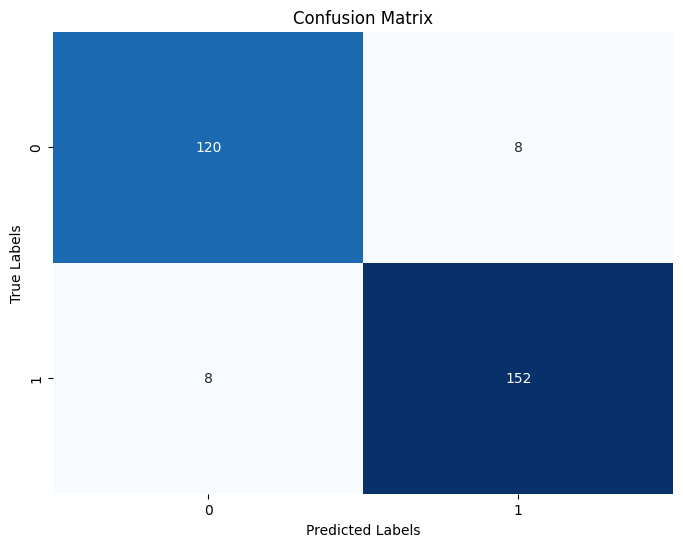

In [14]:
# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
